In [24]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
caminho_pastas = "/content/drive/MyDrive/Image_Classifier/Iris"

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  caminho_pastas,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 421 files belonging to 3 classes.
Using 337 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  caminho_pastas,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 421 files belonging to 3 classes.
Using 84 files for validation.


In [8]:
classes = train_ds.class_names
print(classes)

['iris-setosa', 'iris-versicolour', 'iris-virginica']


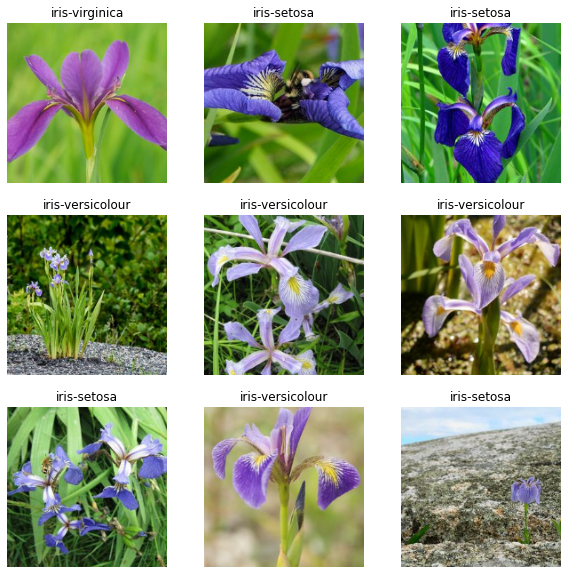

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
camada_normalizada = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (camada_normalizada(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
n_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(n_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 22s 2s/step - loss: 1.1386 - accuracy: 0.5638 - val_loss: 0.9406 - val_accuracy: 0.6190
Epoch 2/10
11/11 [==============================] - 10s 938ms/step - loss: 0.8791 - accuracy: 0.6439 - val_loss: 0.9504 - val_accuracy: 0.6190
Epoch 3/10
11/11 [==============================] - 10s 939ms/step - loss: 0.8429 - accuracy: 0.6528 - val_loss: 0.9686 - val_accuracy: 0.6190
Epoch 4/10
11/11 [==============================] - 10s 949ms/step - loss: 0.7951 - accuracy: 0.6439 - val_loss: 0.9434 - val_accuracy: 0.6071
Epoch 5/10
11/11 [==============================] - 10s 939ms/step - loss: 0.6775 - accuracy: 0.6944 - val_loss: 0.9399 - val_accuracy: 0.6310
Epoch 6/10
11/11 [==============================] - 10s 946ms/step - loss: 0.5198 - accuracy: 0.7893 - val_loss: 0.9418 - val_accuracy: 0.6071
Epoch 7/10
11/11 [==============================] - 10s 944ms/step - loss: 0.4080 - accuracy: 0.8605 - val_loss: 1.1385 - val_accuracy: 0.6071
Ep

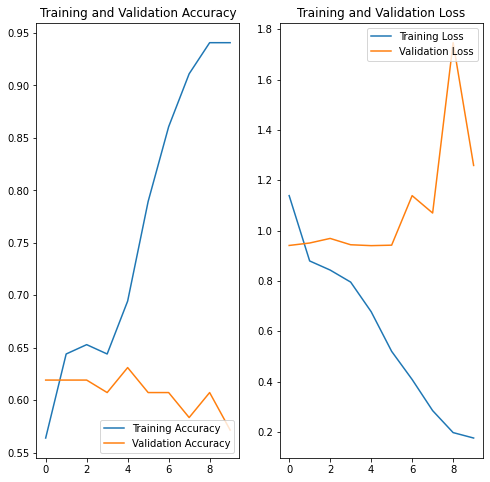

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

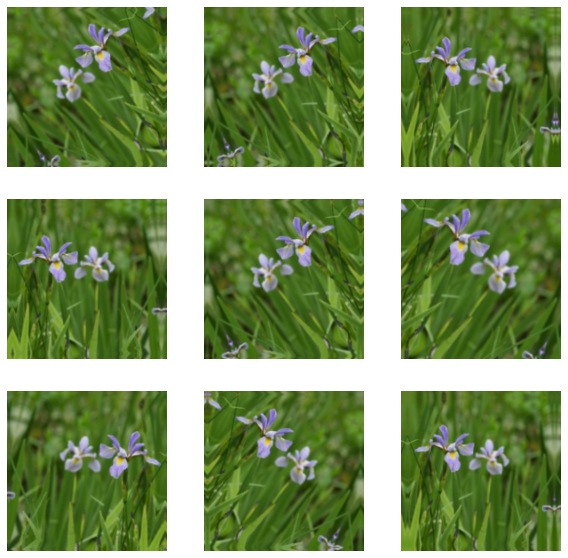

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
#teste = "/content/drive/MyDrive/Image_Classifier/Iris/iris-virginica/iris-0f612632106cde3e540e50d8e798ab31a1f88e61d9d82c6033caf97141d95db8.jpg"
teste = "/content/drive/MyDrive/Image_Classifier/Iris/iris-versicolour/iris-05baeb3abc875aa3cd4b90ff5bf9e9a7457f496bde32786cdfb5ea25ff1ef74c.jpg"


img = keras.preprocessing.image.load_img(
    teste, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Essa classe pertence a classe {} com {:.2f}% de precisão."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

Essa classe pertence a classe iris-versicolour com 91.74% de precisão.


In [27]:
fig = px.imshow(img)
fig.show()